# Do logarithmic proximity measures outperform plain ones in graph clustering?

In [1]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append('../..')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import adjusted_rand_score
from joblib import Parallel, delayed
from collections import defaultdict

In [3]:
from pygraphs.graphs.generator import StochasticBlockModel
from pygraphs.graphs.dataset import Datasets
from pygraphs.measure import ALL_kernels
from pygraphs.cluster import KernelKMeansSklearn
from pygraphs.scenario import ParallelByGraphs, measures_right_order, d3_right_order
from pygraphs.util import load_or_calc_and_save, configure_logging
from pygraphs.scorer import copeland

In [4]:
import logging
configure_logging()
logger = logging.getLogger()

## 6. Cluster analysis on several classical datasets

For each dataset and each measure family, we sorted 55 values of the family parameter in the descending order of the
corresponding ARI. ARI against the rank of the family parameter value is shown in Fig. 9.

In [5]:
all_datasets = Datasets().all

In [6]:
def perform(classic_plot, dataset):
    dataset_results = {}
    graphs, info = dataset
    print(info)
    for measure_class in tqdm(ALL_kernels, desc=info['name']):
        x, y, error = classic_plot.perform(KernelKMeansSklearn, measure_class, graphs, info['k'], n_jobs=1)
        dataset_results[measure_class.name] = (x, y)
    print(info['name'], 'completed')
    return info['name'], dataset_results


@load_or_calc_and_save('results/6_1b_2.pkl')
def calc():
    classic_plot = ParallelByGraphs(adjusted_rand_score, np.linspace(0, 1, 51), progressbar=False)
    results = {}
    for dataset in all_datasets:
        try:
            print(dataset[1]['name'])
            dataset_name, dataset_results = perform(classic_plot, dataset)
            results[dataset_name] = dataset_results
            print(dataset_results)
        except Exception as e:
            print("Fall on {}".format(dataset[1]['name']))
            print(e)
    return results
#     return dict(Parallel(n_jobs=6)(delayed(perform)(classic_plot, dataset) for dataset in all_datasets))
    

results = calc()

File exist! Skip calculations


cora


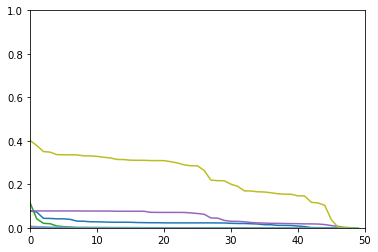

football


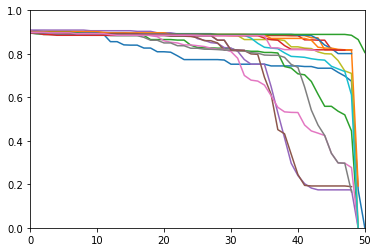

news_2cl_1


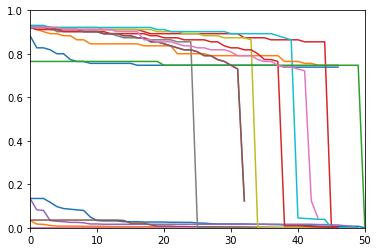

news_2cl_2


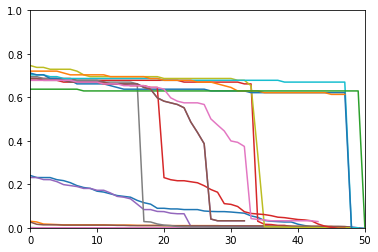

news_2cl_3


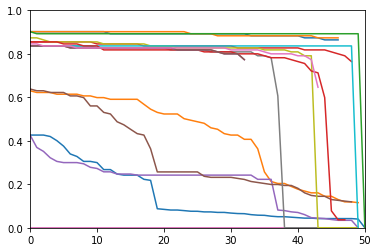

news_3cl_1


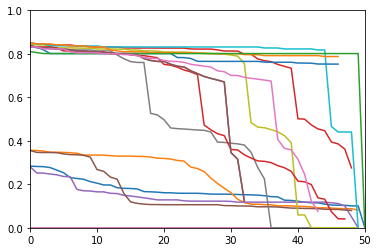

news_3cl_2


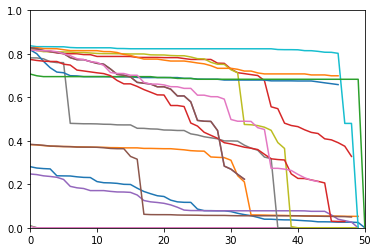

news_3cl_3


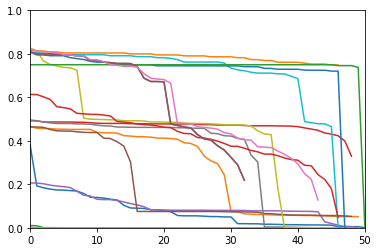

news_5cl_1


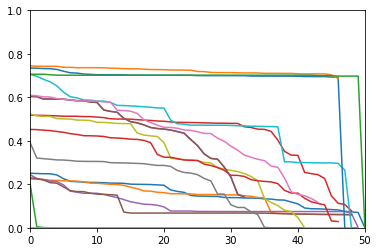

news_5cl_2


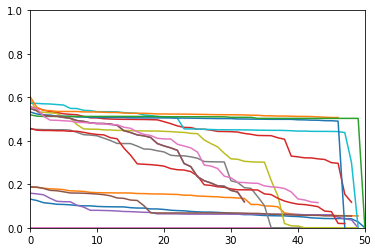

news_5cl_3


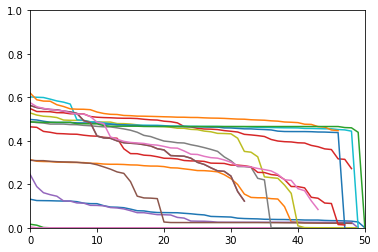

polbooks


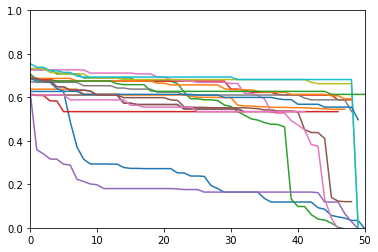

webkb_cornell


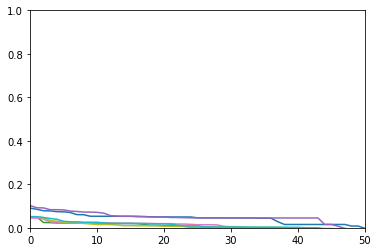

webkb_texas


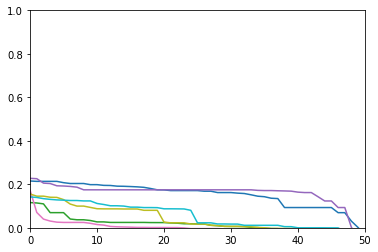

webkb_washington


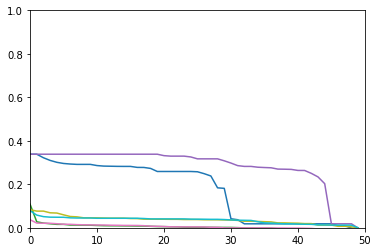

webkb_wisconsin


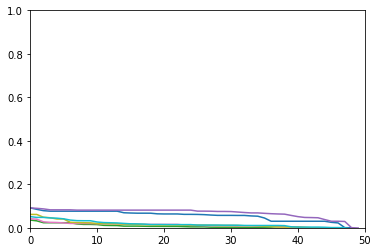

zachary


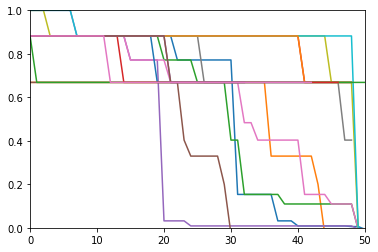

In [10]:
for dataset_name, measure_results in results.items():
    print(dataset_name)
    d3c = (x for x in d3_right_order)
    for measure_name in measures_right_order:
        x, y = measure_results[measure_name]
        plt.plot(range(len(y)), sorted(y, reverse=True), color=d3c.__next__()[0])
    plt.xlim(0, 50)
    plt.ylim(0, 1)
    plt.show()

In [8]:
results

{'cora': {'pWalk H': (array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
          0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
          0.44, 0.46, 0.48, 0.5 , 0.52, 0.56, 0.58, 0.6 , 0.62, 0.64, 0.66,
          0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86, 0.88,
          0.9 , 0.92, 0.94, 0.96, 1.  ]),
   array([ 0.00039824,  0.00576553,  0.02263988,  0.02263988,  0.02263988,
           0.02263988,  0.02263988,  0.02263988,  0.02263988,  0.02220336,
           0.02327132,  0.02327132,  0.00094126,  0.02057234, -0.00189327,
          -0.00189327,  0.02533785,  0.04128937,  0.04128937,  0.02566891,
           0.02566891,  0.02259993,  0.02587255,  0.0275816 ,  0.02777803,
           0.02234255,  0.01110426,  0.01868969,  0.02669662,  0.01120598,
           0.01045815,  0.01739105,  0.01972438,  0.01422882,  0.00033004,
           0.00812332,  0.00071765,  0.02373063,  0.00036427,  0.01401326,
           0.04357828,  0.07225023,

In [14]:
percentile_params = results

In [30]:
results2 = defaultdict(lambda: defaultdict(lambda: 0))
for graphs, info in all_datasets:
    success = 0
    for edges, nodes in tqdm(graphs, desc=str(info['name'])):
        try:
            single_competition_best = {}
            for kernel_class in ALL_kernels:
                best_param_idx = np.argmax(percentile_params[info['name']][kernel_class.name][1])
                best_param = percentile_params[info['name']][kernel_class.name][0][best_param_idx]
                kernel = kernel_class(edges)
                param = kernel.scaler.scale(best_param)
                K = kernel.get_K(param)
                y_pred = KernelKMeansSklearn(info['k']).predict(K)
                ari = adjusted_rand_score(nodes, y_pred)
                single_competition_best[kernel_class.name] = ari
            single_competition_score = copeland(single_competition_best.items())
            for measure_name, delta in single_competition_score.items():
                results2[info['name']][measure_name] += delta
                results2['sum'][measure_name] += delta
            success += 1
        except Exception or FloatingPointError as e:
            print(e)
        if success == 200:
            break

attempt to get argmax of an empty sequence


'polblogs'


attempt to get argmax of an empty sequence


attempt to get argmax of an empty sequence


attempt to get argmax of an empty sequence


attempt to get argmax of an empty sequence


In [28]:
percentile_params[info['name']]

{'pWalk H': (array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
         0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
         0.44, 0.46, 0.48, 0.5 , 0.52, 0.56, 0.58, 0.6 , 0.62, 0.64, 0.66,
         0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86, 0.88,
         0.9 , 0.92, 0.94, 0.96, 1.  ]),
  array([ 0.00039824,  0.00576553,  0.02263988,  0.02263988,  0.02263988,
          0.02263988,  0.02263988,  0.02263988,  0.02263988,  0.02220336,
          0.02327132,  0.02327132,  0.00094126,  0.02057234, -0.00189327,
         -0.00189327,  0.02533785,  0.04128937,  0.04128937,  0.02566891,
          0.02566891,  0.02259993,  0.02587255,  0.0275816 ,  0.02777803,
          0.02234255,  0.01110426,  0.01868969,  0.02669662,  0.01120598,
          0.01045815,  0.01739105,  0.01972438,  0.01422882,  0.00033004,
          0.00812332,  0.00071765,  0.02373063,  0.00036427,  0.01401326,
          0.04357828,  0.07225023,  0.01978767,  0.03876

In [26]:
kernel_class.name

'Walk H'

In [32]:
print('\t'.join(measures_right_order))
for column_name, column_results in results2.items():
    print('{}\t'.format(column_name), end=" ")
    for measure_name in measures_right_order:
        measure_results = column_results[measure_name]
        print('{}\t'.format(measure_results), end=" ")
    print()

pWalk H	Walk H	For H	logFor H	Comm H	logComm H	Heat H	logHeat H	SCT H	SCCT H	RSP K	FE K	SP-CT H	NormalizedHeat R	PersonalizedPageRank R	ModifiedPersonalizedPageRank R	HeatPersonalizedPageRank R
football	 14	 8	 -11	 -11	 16	 10	 12	 -16	 -11	 4	 -1	 6	 -1	 -11	 -5	 -5	 2	 
sum	 -80	 -90	 -133	 43	 -69	 -90	 -116	 -8	 106	 134	 62	 129	 14	 -26	 40	 40	 44	 
news_2cl_1	 -7	 -12	 -15	 9	 -7	 -10	 -15	 9	 9	 16	 -2	 1	 -4	 1	 9	 9	 9	 
news_2cl_2	 -6	 -10	 -14	 6	 -8	 -12	 -16	 8	 16	 10	 12	 14	 -4	 -1	 3	 3	 -1	 
news_2cl_3	 -11	 -8	 -16	 7	 -11	 -6	 -14	 0	 10	 -4	 16	 14	 12	 7	 0	 0	 4	 
news_3cl_1	 -10	 -7	 -16	 12	 -12	 -7	 -14	 8	 10	 16	 6	 14	 -4	 4	 -1	 -1	 2	 
news_3cl_2	 -10	 -8	 -14	 2	 -12	 -6	 -16	 0	 8	 16	 6	 14	 -4	 -2	 11	 11	 4	 
news_3cl_3	 -10	 -6	 -14	 -2	 -12	 -8	 -16	 -4	 16	 10	 8	 14	 2	 0	 5	 5	 12	 
news_5cl_1	 -6	 -12	 -14	 0	 -8	 -10	 -16	 -4	 2	 10	 14	 16	 12	 -2	 5	 5	 8	 
news_5cl_2	 -12	 -8	 -14	 10	 -10	 -6	 -16	 -4	 14	 12	 2	 16	 0	 -2	 5	 5	 8	 
ne